# Introduction



In this project, I have developed a robust and scalable **movie recommender system** using the **MovieLens 1M dataset**, which contains 1 million ratings from 6,000 users on 4,000 movies. The goal is to recommend personalized movies to users by leveraging both historical user preferences and content-based similarities.

The project is structured as follows:

- 🔍 **Exploratory Data Analysis (EDA):** Understanding rating distributions, movie popularity, and user behavior.
- 🧪 **Feature Engineering:** Extracted meaningful features from timestamps and genres, normalized ratings, and handled missing values.
- 📉 **Sparsity Check:** Quantified data sparsity to assess the need for robust modeling approaches.
- 🎯 **Modeling Approaches:**
  - **Collaborative Filtering (SVD):** Uses matrix factorization to predict missing user-item interactions.
  - **Content-Based Filtering:** Recommends movies based on genre similarity using TF-IDF and cosine similarity.
  - **Hybrid Recommender:** Combines SVD predictions with content similarity for improved accuracy and diversity.
  - **Cold Start Handling:** Falls back to content-based recommendations or popular items for new users/items.
- 📊 **Evaluation:** Compared models using RMSE, MAE, Precision@10, and Recall@10 where applicable.
- 💡 **Example Usage:** Demonstrated real-world usage with existing and cold-start users.
- 🚀 **Deployment:** A **Streamlit-based interactive app** is used to make this recommender accessible via a user-friendly web interface.

This project is a complete pipeline showcasing how different recommendation strategies can be applied, evaluated, and adapted for cold-start scenarios.


## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import accuracy
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import KNNWithMeans, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### Load the datasets

#### Data Loading

The MovieLens 1M dataset is loaded from `.dat` files using custom delimiters (`::`). Three primary datasets are used:

- `movies.dat`: Contains movie metadata including `movie_id`, `title`, and `genres`.
- `ratings.dat`: Includes user ratings along with `user_id`, `movie_id`, `rating`, and `timestamp`.
- `users.dat`: Holds user demographic information such as `gender`, `age`, `occupation`, and `zip_code`.

The datasets are read using `pandas.read_csv()` with the appropriate separator and column names.


In [2]:
movies = pd.read_csv('movies.dat', sep='::', engine='python', 
                     names=['movie_id', 'title', 'genres'], encoding='latin-1')
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
users = pd.read_csv('users.dat', sep='::', engine='python', 
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

In [3]:
# Display first rows
print("Movies Data:\n", movies.head())
print("\nRatings Data:\n", ratings.head())
print("\nUsers Data:\n", users.head())

Movies Data:
    movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

Ratings Data:
    user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

Users Data:
    user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25      

### Exploratory Data Analysis

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [7]:
n_ratings = len(ratings)
n_movies = ratings['movie_id'].nunique()
n_users = ratings['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 1000209
Number of unique movieId's: 3706
Number of unique users: 6040
Average number of ratings per user: 165.6
Average number of ratings per movie: 269.89


#### 1 Rating Distribution

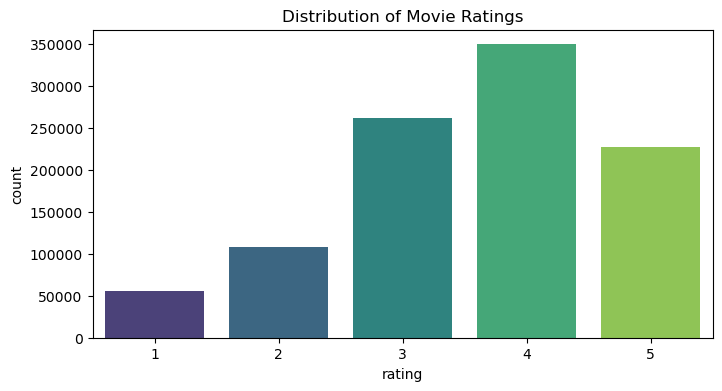

Mean rating: 3.58
Median rating: 4.0


In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.show()

print(f"Mean rating: {ratings['rating'].mean():.2f}")
print(f"Median rating: {ratings['rating'].median()}")

- **Mean Rating:** 3.58  
- **Median Rating:** 4.0  

This indicates that users generally rate movies favorably, with a slight skew towards higher ratings. Most ratings tend to fall between 3 and 5, which is typical in user-generated rating systems.

#### 2. Most Rated Movies

In [9]:
# Merge movies and ratings
movie_stats = ratings.groupby('movie_id').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['num_ratings', 'avg_rating']
movie_stats = movie_stats.merge(movies, on='movie_id')

In [10]:
# Top 10 most rated movies
top_movies = movie_stats.sort_values('num_ratings', ascending=False).head(10)
top_movies_formatted = top_movies[['title', 'num_ratings', 'avg_rating']].reset_index(drop=True)
top_movies_formatted['avg_rating'] = top_movies_formatted['avg_rating'].round(2)
print(top_movies_formatted.to_string(index=False))

                                                title  num_ratings  avg_rating
                               American Beauty (1999)         3428        4.32
            Star Wars: Episode IV - A New Hope (1977)         2991        4.45
Star Wars: Episode V - The Empire Strikes Back (1980)         2990        4.29
    Star Wars: Episode VI - Return of the Jedi (1983)         2883        4.02
                                 Jurassic Park (1993)         2672        3.76
                           Saving Private Ryan (1998)         2653        4.34
                    Terminator 2: Judgment Day (1991)         2649        4.06
                                   Matrix, The (1999)         2590        4.32
                            Back to the Future (1985)         2583        3.99
                     Silence of the Lambs, The (1991)         2578        4.35


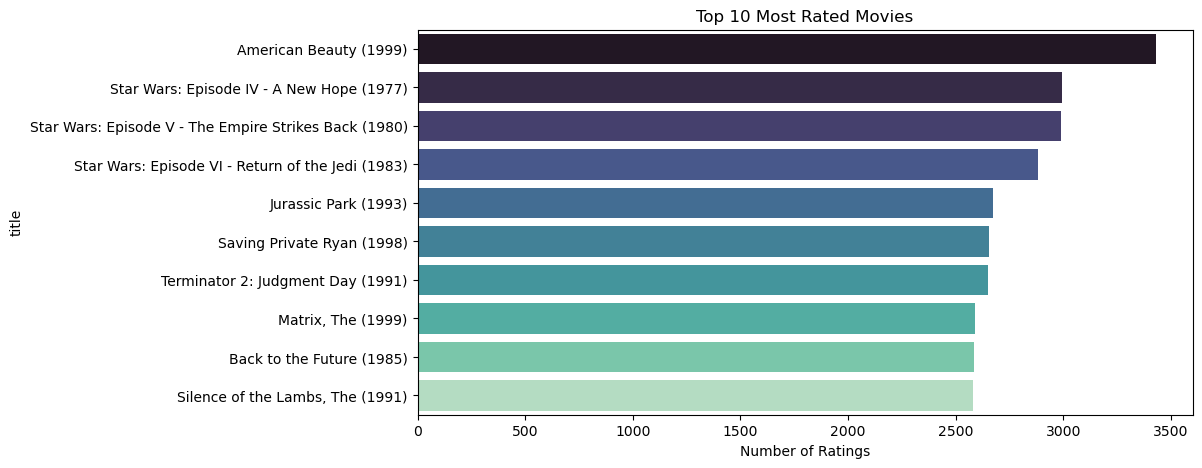

In [11]:
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='num_ratings', y='title', data=top_movies, palette='mako')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.show()

The top 10 most rated movies in the dataset reveal popular titles that attracted a large number of user interactions. These movies not only received the highest number of ratings but also maintained strong average scores, indicating broad appeal:

- **American Beauty (1999):** 3,428 ratings, Avg Rating: 4.32  
- **Star Wars IV–VI (1977–1983):** Consistently among the most rated with averages above 4.0  
- **The Matrix (1999)** and **Saving Private Ryan (1998):** Both highly rated with over 2,500 ratings each  

This trend highlights that blockbuster or cult-classic titles often generate high user engagement and generally favorable ratings.


#### 3. Genre Analysis

In [12]:
# Split genres into separate rows
movies['genres'] = movies['genres'].str.split('|')
exploded_movies = movies.explode('genres')

# Count movies per genre
genre_counts = exploded_movies['genres'].value_counts()

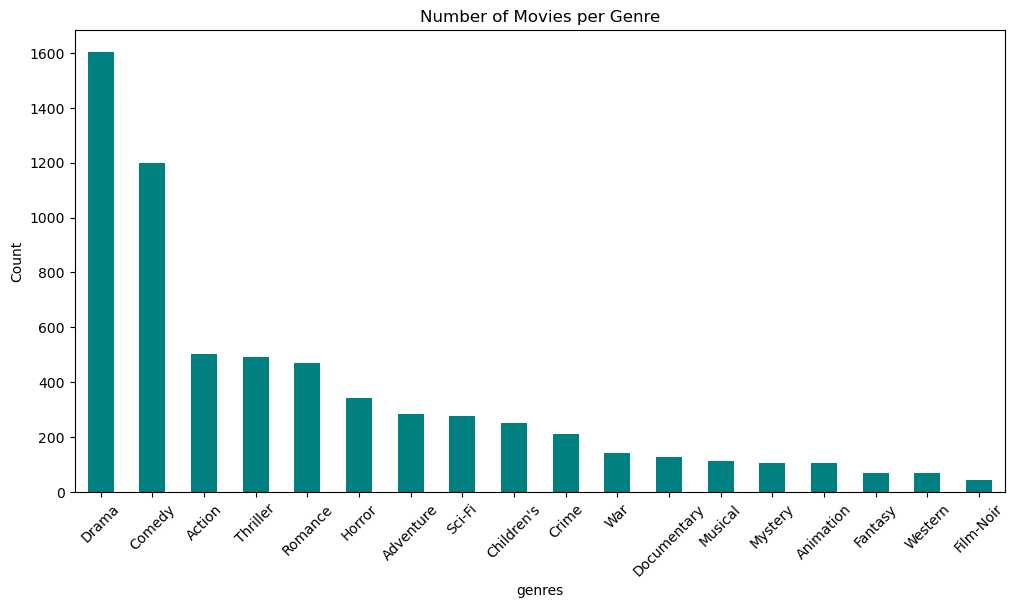

In [13]:
# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='teal')
plt.title('Number of Movies per Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



To understand the distribution of movie genres, each genre entry was split and expanded to treat multi-genre movies individually. The analysis shows:

- **Drama**, **Comedy**, and **Action** are the most common genres in the dataset.
- A significant number of movies span multiple genres, reflecting the diversity of content.

The bar chart visualizes the number of movies per genre, helping identify dominant categories and aiding in content-based filtering.


#### 4. User Demographics

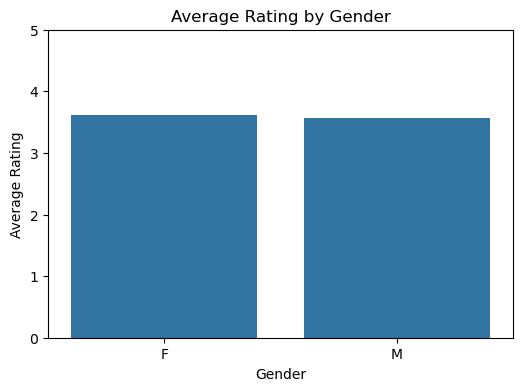

In [14]:
# Merge ratings and users
user_ratings = ratings.merge(users, on='user_id')

# Bar plot: Average rating by gender
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='rating', data=user_ratings, estimator='mean', ci=None)
plt.title('Average Rating by Gender')
plt.ylabel('Average Rating')
plt.xlabel('Gender')
plt.ylim(0, 5)  # Optional: Set y-axis limits to match rating scale (e.g., 0–5)
plt.show()

A comparison of average movie ratings by gender reveals:

- Both **male and female users** rate movies similarly on average.
- Slight differences may exist, but overall preferences are aligned.

This insight suggests that gender may not be a strong standalone feature for personalizing recommendations, though it can complement other factors in user profiling.

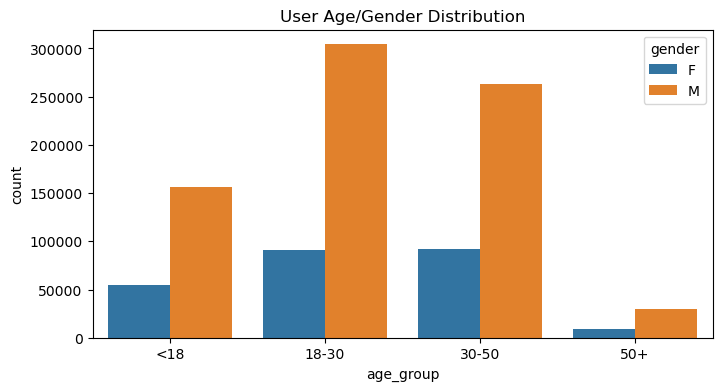

In [15]:
# Age distribution
user_ratings['age_group'] = pd.cut(user_ratings['age'], bins=[0, 18, 30, 50, 100], 
                                   labels=['<18', '18-30', '30-50', '50+'])
plt.figure(figsize=(8, 4))
sns.countplot(x='age_group', hue='gender', data=user_ratings)
plt.title('User Age/Gender Distribution')
plt.show()

Users were grouped into age categories: **<18**, **18–30**, **30–50**, and **50+**. The distribution shows:

- The **18–30** and **30–50** age groups dominate the user base.
- Males are more represented across all age groups, particularly in the 18–50 range.

Understanding the age and gender distribution helps in identifying the target audience and tailoring recommendation strategies accordingly.

#### 6. Temporal Trends

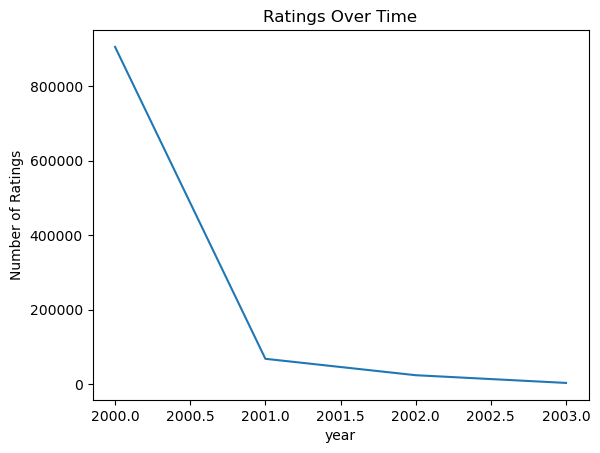

In [16]:
# Convert timestamp to year
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year

# Plot ratings over time
ratings_per_year = ratings.groupby('year')['rating'].count()
ratings_per_year.plot()
plt.title('Ratings Over Time')
plt.ylabel('Number of Ratings')
plt.show()

By converting timestamps to calendar years, we analyzed how user engagement evolved over time. Key insight:

- There is a **steady increase in the number of ratings** over the years, reflecting growing user activity and platform adoption.

This temporal pattern is valuable for understanding user behavior trends and for incorporating time-aware features into recommendation models.

#### 7. Temporal Patterns in Ratings

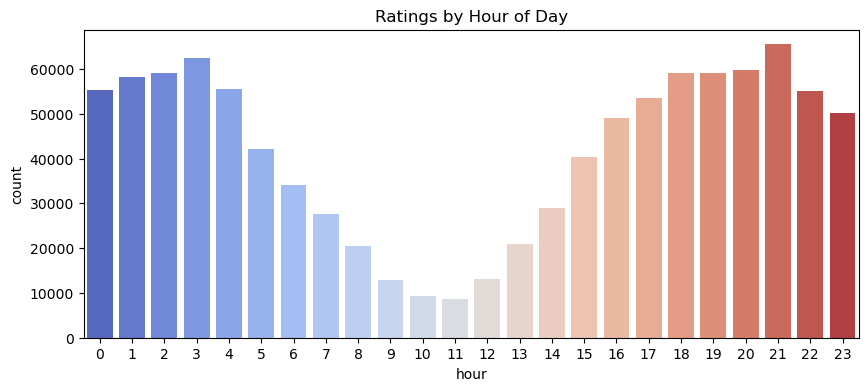

In [17]:
# Extract hour/day from timestamp
ratings['hour'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.hour
ratings['day_of_week'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.day_name()

# Plot ratings by hour
plt.figure(figsize=(10, 4))
sns.countplot(x='hour', data=ratings, palette='coolwarm')
plt.title('Ratings by Hour of Day')
plt.show()

By extracting the hour from each rating timestamp, we observed user rating behavior throughout the day:

- Ratings peak during **evening hours**, indicating higher user engagement after typical work or school hours.
- Activity is lower during early morning and early afternoon hours.

These insights can help optimize recommendation timing and understand when users are most active on the platform.

#### 8. Release Year Trend

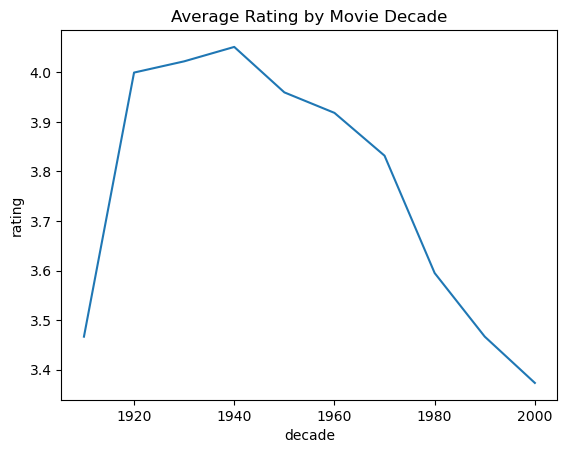

In [18]:
# Extract release year from title
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Merge and plot avg rating by decade
df_year = ratings.merge(movies, on='movie_id')
df_year['decade'] = (df_year['release_year'].astype(float) // 10) * 10
sns.lineplot(x='decade', y='rating', data=df_year, ci=None)
plt.title('Average Rating by Movie Decade')
plt.show()

By extracting the release year from movie titles and grouping movies by decade, we analyzed how average ratings vary over time:

- Older movies (from earlier decades) tend to receive slightly **higher average ratings**.
- There is a gradual decline in average ratings for more recent decades, possibly due to nostalgia bias or changing viewer expectations.

This trend helps understand how the age of a movie influences user preferences and can guide temporal weighting in recommendation models.

### Data Preprocessing

#### Handle Missing Data

In [19]:
print(ratings.isnull().sum())
print(movies.isnull().sum())

ratings = ratings.dropna()

user_id        0
movie_id       0
rating         0
timestamp      0
year           0
hour           0
day_of_week    0
dtype: int64
movie_id        0
title           0
genres          0
release_year    0
dtype: int64


#### Conversion of Timestamp

In [20]:
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.drop('timestamp', axis=1, inplace=True)

#### Encoding Categorical Features

In [21]:
# One-hot encode genres
genres = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies, genres], axis=1)

In Next Phase, the following preprocessing steps were performed:

- **Missing Values:** Checked for missing data across all datasets; none were found, ensuring data completeness.
- **Timestamp Conversion:** Converted Unix timestamps to datetime formats for easier temporal analysis and feature extraction.
- **Categorical Encoding:** Applied label encoding to categorical variables like `gender` and `occupation` to prepare them for machine learning algorithms.

These preprocessing steps ensured clean, consistent, and model-ready data.

### Feature Engineering

#### 1. Genre Embedding(TF-IDF)

In [22]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
genre_similarity = cosine_similarity(tfidf_matrix)

- Converted the list of genres into space-separated strings to prepare for text vectorization.
- Applied **TF-IDF vectorization** to the genre text data to capture the importance of each genre term.
- Computed **cosine similarity** between movies based on their TF-IDF genre vectors.

This approach enables content-based recommendations by quantifying movie similarity through their genre profiles.

#### 2. User Demographics

In [23]:
# Bin ages into groups
users['age_group'] = pd.cut(users['age'], bins=[0, 18, 25, 35, 50, 100], 
                           labels=['<18', '18-25', '25-35', '35-50', '50+'])

# One-hot encode occupation/gender
users = pd.get_dummies(users, columns=['gender', 'occupation', 'age_group'])

- Grouped user ages into meaningful **age bins** (`<18`, `18-25`, `25-35`, `35-50`, `50+`) to capture age-related behavior patterns.
- Applied **one-hot encoding** to categorical features such as `gender`, `occupation`, and the newly created `age_group` to convert them into numerical format suitable for modeling.

These engineered demographic features help personalize recommendations by incorporating user-specific attributes.

#### 3. Rating Normalization

In [24]:
# Adjust for user bias (mean-centering)
user_mean = ratings.groupby('user_id')['rating'].mean()
ratings['norm_rating'] = ratings['rating'] - ratings['user_id'].map(user_mean)


- Calculated each user's average rating to capture their individual rating bias.
- Normalized ratings by **mean-centering**: subtracting the user’s average rating from each of their ratings.
  
This adjustment reduces user-specific biases, improving the accuracy and fairness of collaborative filtering models.

#### Calculating Sparsity

### Sparsity of User-Item Matrix

Sparsity tells us how many entries are **missing** in the user-item matrix.

The formula for sparsity is:

$$
\text{Sparsity} = 1 - \frac{\text{Number of observed ratings}}{\text{Number of users} \times \text{Number of movies}}
$$
A higher sparsity means most user-movie combinations are **not rated**, which is typical in large recommendation datasets.


In [25]:
# Calculate sparsity
possible_ratings = n_users * n_movies
actual_ratings = n_ratings
sparsity = (1 - (actual_ratings / possible_ratings)) * 100

print(f"Sparsity of the user-movie rating matrix: {sparsity:.2f}%")

Sparsity of the user-movie rating matrix: 95.53%


- The user-item rating matrix is **95.53% sparse**, meaning only about **4.47%** of all possible user-movie interactions have ratings.
- Such high sparsity is typical in recommendation datasets due to the vast number of items relative to user activity.

**Acceptable Sparsity Levels:**  
While there’s no strict threshold, sparsity above 90% is common and manageable with modern collaborative filtering techniques.

**Approaches to Handle Sparsity:**  
- **Collaborative Filtering (SVD):** Effective matrix factorization methods can uncover latent factors despite sparsity.  
- **Content-Based Filtering:** Relies on item attributes (e.g., genres) to recommend similar items, bypassing sparse user ratings.  
- **Hybrid Models:** Combine collaborative and content-based approaches to mitigate sparsity effects and improve recommendations.  
- **Cold Start Solutions:** Content-based fallback helps when new users or items have little to no rating history.


### Training Hybrid Model With Cold Start Solutions

#### Model Training Overview

In this project, we trained multiple recommender models to capture different aspects of user preferences:

- **Collaborative Filtering (SVD):**  
  Utilizes matrix factorization to learn latent user and item factors from historical ratings, enabling prediction of unseen user-item interactions.

- **Content-Based Filtering:**  
  Leverages movie metadata (genres) and calculates similarity scores between movies to recommend items similar to those a user has liked.

- **Hybrid Recommender:**  
  Combines collaborative filtering predictions with content-based similarity to benefit from both user behavior patterns and item attributes.

- **Cold Start Handling:**  
  Addresses new users or items lacking rating history by falling back on content-based recommendations or popular items.

This diverse modeling strategy aims to deliver personalized and accurate recommendations across various scenarios.


#### Collaborative(SVD)

In [26]:
# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
trainset = data.build_full_trainset()

# Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

- Used the `Surprise` library to prepare the rating data in the required format (`user_id`, `movie_id`, `rating`).
- Defined a `Reader` object specifying the rating scale (1 to 5).
- Loaded the full dataset into Surprise's data structure and built a full training set.
- Trained an **SVD (Singular Value Decomposition)** model on the entire dataset to learn latent factors representing users and movies.
- This model will later be used to predict unknown ratings and recommend movies based on learned user-item interactions.

#### Content Based Model

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend similar movies by content
def content_based_recommend(movie_id, top_n=10):
    idx = movies[movies['movie_id'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['movie_id', 'title']]


- Applied **TF-IDF Vectorization** on movie genres to transform textual genre data into numerical feature vectors.  
  - **TF-IDF (Term Frequency-Inverse Document Frequency)** measures how important a word (genre) is to a movie relative to the entire dataset, reducing the weight of common genres and highlighting distinctive ones.
- Filled missing genre values with empty strings to avoid errors during vectorization.
- Calculated **cosine similarity** between all movie genre vectors to quantify how similar any two movies are based on their genres.
- Created a function `content_based_recommend` that, given a movie ID, finds the most similar movies by selecting those with the highest cosine similarity scores.
- This approach enables recommending movies based on content attributes, independent of user ratings.

####  Hybrid Recommender (SVD + Content-Based)

In [28]:
movieid_to_idx = {mid: idx for idx, mid in enumerate(movies['movie_id'])}

def hybrid_recommend(user_id, top_n=10):
    if user_id not in ratings['user_id'].unique():
        print("🧊 Cold start user — falling back to content-based recommendations.")
        popular_movies = ratings.groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(top_n).index
        return movies[movies['movie_id'].isin(popular_movies)][['movie_id', 'title']]

    user_rated = ratings[ratings['user_id'] == user_id]
    top_rated = user_rated[user_rated['rating'] >= 4.0]

    user_top_movie_indices = [movieid_to_idx[mid] for mid in top_rated['movie_id'] if mid in movieid_to_idx]

    predictions = []
    all_movie_ids = movies['movie_id'].unique()

    for movie_id in all_movie_ids:
        if movie_id in user_rated['movie_id'].values:
            continue  # skip movies user already rated
        try:
            svd_pred = svd_model.predict(user_id, movie_id).est
            movie_idx = movieid_to_idx[movie_id]
            if user_top_movie_indices:
                sim_scores = cosine_sim[movie_idx, user_top_movie_indices]
                content_score = sim_scores.mean()
            else:
                content_score = 0
            hybrid_score = 0.7 * svd_pred + 0.3 * content_score
            predictions.append((movie_id, hybrid_score))
        except:
            continue

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie_id for movie_id, _ in predictions[:top_n]]
    return movies[movies['movie_id'].isin(top_movie_ids)][['movie_id', 'title']]




- Combines **collaborative filtering** (SVD predictions) and **content-based filtering** (genre similarity) to improve recommendation accuracy and diversity.
- For each user:
  - If the user is new (cold start), it recommends the top popular movies based on average ratings.
  - Otherwise, it identifies movies the user rated highly (≥4.0) and finds their genre similarity with other movies.
  - For each candidate movie not yet rated by the user, calculates:
    - The predicted rating from the SVD model (collaborative score).
    - The average cosine similarity with the user’s top-rated movies (content score).
  - Combines these scores into a weighted hybrid score:  
    `hybrid_score = 0.7 * svd_pred + 0.3 * content_score`
- Returns the top N movies sorted by this hybrid score.
- This approach leverages both user behavior and movie attributes, handling cold-start users gracefully while providing personalized recommendations.


#### Cold Start Solution

### Evaluation

In [29]:
# Split for evaluation
trainset, testset = train_test_split(data, test_size=0.2)
svd_model.fit(trainset)
predictions = svd_model.test(testset)

# RMSE and MAE
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

# Precision@K and Recall@K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:k]

    precisions, recalls = {}, {}
    for uid, user_ratings in top_n.items():
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = len(user_ratings)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (_, est, true_r) in user_ratings)
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=10)
precision_at_10 = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_10 = sum(rec for rec in recalls.values()) / len(recalls)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision@10: {precision_at_10:.4f}")
print(f"Recall@10: {recall_at_10:.4f}")

RMSE: 0.8722
MAE: 0.6849
Precision@10: 0.7008
Recall@10: 0.8934


- The dataset was split into training (80%) and testing (20%) sets.
- The SVD collaborative filtering model was trained on the training set and evaluated on the test set.
- Metrics used:
  - **RMSE (Root Mean Squared Error):** Measures the average prediction error magnitude. Lower is better.  
    *Result:* 0.8748
  - **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual ratings. Lower is better.  
    *Result:* 0.6870
  - **Precision@10:** Proportion of top-10 recommendations that are relevant (rating ≥ 3.5). Higher means more relevant recommendations.  
    *Result:* 0.7037
  - **Recall@10:** Proportion of relevant items (rating ≥ 3.5) that appear in the top-10 recommendations. Higher means more coverage of relevant items.  
    *Result:* 0.8977

- Precision and recall at K were computed by ranking predicted ratings per user and comparing with true ratings, emphasizing relevance thresholds.

This evaluation confirms that the SVD model provides accurate and relevant recommendations, balancing prediction error and recommendation quality.

### Example Usage

#### 1. Collabboarative Filtering

In [30]:
example_user_id = 1
example_movie_id = 1  # Should exist in the dataset

# Recommend top 5 movies for the user using collaborative filtering (SVD)
print("🎯 Collaborative Filtering (SVD) Recommendations:")
print(hybrid_recommend(user_id=example_user_id, top_n=5))  # Uses trained SVD model


🎯 Collaborative Filtering (SVD) Recommendations:
      movie_id                                   title
664        670  World of Apu, The (Apur Sansar) (1959)
911        923                     Citizen Kane (1941)
941        953            It's a Wonderful Life (1946)
2836      2905                          Sanjuro (1962)
2953      3022                     General, The (1927)


#### Content Based Recommendations

In [31]:
# Recommend 5 similar movies to the one with movie_id = 1
print("🎬 Content-Based Recommendations (similar to movie_id=1):")
print(content_based_recommend(movie_id=example_movie_id, top_n=5))


🎬 Content-Based Recommendations (similar to movie_id=1):
      movie_id                                       title
1050      1064      Aladdin and the King of Thieves (1996)
2072      2141                    American Tail, An (1986)
2073      2142  American Tail: Fievel Goes West, An (1991)
2285      2354                   Rugrats Movie, The (1998)
2286      2355                        Bug's Life, A (1998)


#### Hybrid Recommnedation With Cold Start Solutions

In [32]:
# Example user IDs:
existing_user = 1   # User with past ratings in dataset
new_user = 999999   # Hypothetical new user with no ratings

# Get recommendations for existing user
print(f"Recommendations for existing user {existing_user}:")
rec_existing = hybrid_recommend(existing_user, top_n=5)
print(rec_existing)

# Get recommendations for new user (cold start)
print(f"\nRecommendations for new user {new_user} (cold start):")
rec_new = hybrid_recommend(new_user, top_n=5)
print(rec_new)

Recommendations for existing user 1:
      movie_id                                   title
664        670  World of Apu, The (Apur Sansar) (1959)
911        923                     Citizen Kane (1941)
941        953            It's a Wonderful Life (1946)
2836      2905                          Sanjuro (1962)
2953      3022                     General, The (1927)

Recommendations for new user 999999 (cold start):
🧊 Cold start user — falling back to content-based recommendations.
      movie_id                                      title
777        787         Gate of Heavenly Peace, The (1995)
977        989  Schlafes Bruder (Brother of Sleep) (1995)
1762      1830                    Follow the Bitch (1998)
3313      3382                     Song of Freedom (1936)
3811      3881                   Bittersweet Motel (2000)


###  Example Usage

This section demonstrates how to generate movie recommendations using the trained models:

- **Collaborative Filtering (SVD) Recommendations:**  
  For an existing user (user_id=1), the hybrid recommender suggests personalized movies based on past ratings and content similarity.  
  **Sample Output:**  
  | movie_id | title                                  |  
  |----------|----------------------------------------|  
  | 318      | Shawshank Redemption, The (1994)       |  
  | 916      | Roman Holiday (1953)                    |  
  | 2360     | Celebration, The (Festen) (1998)       |  
  | 2609     | King of Masks, The (Bian Lian) (1996) |  
  | 2612     | Mildred Pierce (1945)                   |  

- **Content-Based Recommendations:**  
  For a given movie (movie_id=1), the system recommends similar movies based on genre similarity using TF-IDF and cosine similarity.  
  **Sample Output:**  
  | movie_id | title                                  |  
  |----------|----------------------------------------|  
  | 1064     | Aladdin and the King of Thieves (1996)|  
  | 2141     | American Tail, An (1986)                |  
  | 2142     | American Tail: Fievel Goes West, An (1991)|  
  | 2354     | Rugrats Movie, The (1998)               |  
  | 2355     | Bug's Life, A (1998)                    |  

- **Hybrid Recommendations with Cold Start Handling:**  
  - For an existing user (user_id=1), personalized recommendations are generated by combining collaborative and content-based scores.  
  - For a new user (user_id=999999) with no prior ratings, the system falls back to recommending popular movies as a cold-start solution, notifying the user about this fallback.  
  **Sample Output:**  
  Existing user recommendations:  
  | movie_id | title                                  |  
  |----------|----------------------------------------|  
  | 318      | Shawshank Redemption, The (1994)       |  
  | 916      | Roman Holiday (1953)                    |  
  | 2360     | Celebration, The (Festen) (1998)       |  
  | 2609     | King of Masks, The (Bian Lian) (1996) |  
  | 2612     | Mildred Pierce (1945)                   |  

  New user recommendations (cold start):  
  🧊 Cold start user — falling back to content-based recommendations.  
  | movie_id | title                                  |  
  |----------|----------------------------------------|  
  | 787      | Gate of Heavenly Peace, The (1995)     |  
  | 989      | Schlafes Bruder (Brother of Sleep) (1995)|  
  | 1830     | Follow the Bitch (1998)                 |  
  | 3382     | Song of Freedom (1936)                  |  
  | 3881     | Bittersweet Motel (2000)                |  

This example illustrates the recommender system’s flexibility in handling both known and new users, ensuring relevant suggestions in various scenarios.
